In [4]:
#run once before training
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base_dir = '/content/drive/MyDrive/yawn_data'
yawn_videos = '/content/drive/MyDrive/YawDD/yawn'
nonyawn_videos = '/content/drive/MyDrive/YawDD/no_yawn'
cleaned_dir = '/content/drive/MyDrive/FuckedUP YAens'

os.makedirs(cleaned_dir, exist_ok=True)
print("Output folder:", cleaned_dir)


Output folder: /content/drive/MyDrive/FuckedUP YAens


In [ ]:
import os

yawn_out = os.path.join(cleaned_dir, "yawn")
no_yawn_out = os.path.join(cleaned_dir, "no_yawn")

os.makedirs(yawn_out, exist_ok=True)
os.makedirs(no_yawn_out, exist_ok=True)

In [ ]:
!pip install mediapipe opencv-python-headless numpy


In [ ]:
import cv2, numpy as np, os, csv
import mediapipe as mp

mp_face = mp.solutions.face_mesh

def mouth_openness(landmarks, w, h):
    U, L = landmarks[13], landmarks[14]
    left, right = landmarks[61], landmarks[291]
    gap = np.linalg.norm([L.x*w - U.x*w, L.y*h - U.y*h])
    width = np.linalg.norm([right.x*w - left.x*w, right.y*h - left.y*h]) + 1e-6
    return gap / width

def smooth(x, k=9):
    if len(x) < k: return x
    return np.convolve(x, np.ones(k)/k, mode='same')

def find_peaks(sig, thr, min_len):
    peaks, start = [], None
    for i, v in enumerate(sig):
        if v >= thr and start is None:
            start = i
        elif (v < thr or i == len(sig)-1) and start is not None:
            end = i if v < thr else i
            if end - start + 1 >= min_len:
                peaks.append((start, end))
            start = None
    return peaks

def process_video(path, out_root, tag_hint=None, yawn_thr=0.45, min_yawn_sec=1.2):
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    stride = int(fps // 10)  # sample ~10fps
    openness, frames = [], []
    with mp_face.FaceMesh(max_num_faces=1, refine_landmarks=True) as fm:
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            if i % stride != 0:
                i += 1; continue
            h, w = frame.shape[:2]
            res = fm.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if res.multi_face_landmarks:
                lm = res.multi_face_landmarks[0].landmark
                openness.append(mouth_openness(lm, w, h))
                frames.append((i, frame, lm, (w, h)))
            i += 1
    cap.release()
    if not openness: return

    s = smooth(openness, k=9)
    min_len = int(min_yawn_sec * 10)
    peaks = find_peaks(s, yawn_thr, min_len)

    csv_path = os.path.join(out_root, "labels.csv")
    writer = csv.writer(open(csv_path, "a", newline=""))

    def save_crop(tag, idx, frame, lm, wh):
        w, h = wh
        left = np.array([lm[61].x*w, lm[61].y*h], int)
        right = np.array([lm[291].x*w, lm[291].y*h], int)
        cx, cy = ((left + right) // 2)
        mw = int(1.8 * np.linalg.norm(right - left))
        mh = int(1.6 * mw)
        x1 = max(0, cx - mw//2); y1 = max(0, cy - mh//2)
        x2 = min(w, cx + mw//2); y2 = min(h, cy + mh//2)
        crop = frame[y1:y2, x1:x2]
        if crop.size == 0: return
        fn = f"{tag}_{os.path.splitext(os.path.basename(path))[0]}_{idx}.jpg"

# choose output folder based on tag
        subdir = "yawn" if tag == "yawn" else "no_yawn"
        out_path = os.path.join(out_root, subdir, fn)

        cv2.imwrite(out_path, crop)
        writer.writerow([os.path.join(subdir, fn), tag])

    # Positive crops (detected yawns)
    for (a,b) in peaks:
        mid = (a+b)//2
        if mid < len(frames):
            idx, frame, lm, wh = frames[mid]
            save_crop("yawn", idx, frame, lm, wh)

    # Negatives (far frames)
    non_peaks = [j for j in range(len(frames)) if all(not (a <= j <= b) for (a,b) in peaks)]
    for j in non_peaks[::max(1, len(non_peaks)//20)]:
        idx, frame, lm, wh = frames[j]
        save_crop("no_yawn", idx, frame, lm, wh)


In [ ]:
for folder in [yawn_videos, nonyawn_videos]:
    for file in os.listdir(folder):
        if file.endswith(('.mp4', '.avi', '.mov')):
            fpath = os.path.join(folder, file)
            print("Processing:", fpath)
            process_video(fpath, cleaned_dir,yawn_thr=0.45, min_yawn_sec=1.2)


Processing: /content/drive/MyDrive/YawDD/yawn/17-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/13-MaleGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/4-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/39-MaleGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/34-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/36-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/3-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/24-MaleGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/42-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/25-MaleGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/27-MaleGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/28-MaleNoGlasses-Yawning.avi
Processing: /content/drive/MyDrive/YawDD/yawn/38-MaleSunGlasses-Yawning.avi
Processing: /content/drive/MyDrive/Y

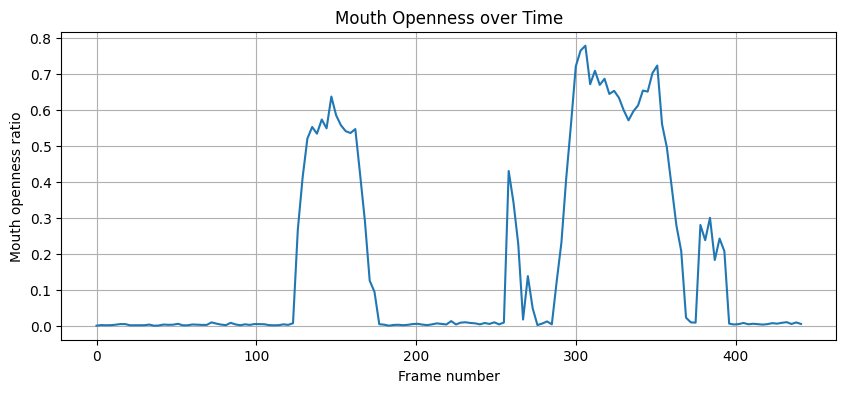

Min: 0.0003211202665050055 Max: 0.7785589925610343 Median: 0.007366196524959181


In [ ]:
import matplotlib.pyplot as plt
import cv2, numpy as np
import mediapipe as mp

mp_face = mp.solutions.face_mesh

def mouth_openness(landmarks, w, h):
    U, L = landmarks[13], landmarks[14]
    left, right = landmarks[61], landmarks[291]
    gap = np.linalg.norm([L.x*w - U.x*w, L.y*h - U.y*h])
    width = np.linalg.norm([right.x*w - left.x*w, right.y*h - left.y*h]) + 1e-6
    return gap / width

def compute_openness(video_path):
    cap = cv2.VideoCapture(video_path)
    openness = []
    frame_indices = []
    with mp_face.FaceMesh(max_num_faces=1, refine_landmarks=True) as fm:
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret: break
            if i % 3 != 0:  # sample every 3rd frame for speed
                i += 1; continue
            h, w = frame.shape[:2]
            res = fm.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            if res.multi_face_landmarks:
                lm = res.multi_face_landmarks[0].landmark
                openness.append(mouth_openness(lm, w, h))
                frame_indices.append(i)
            i += 1
    cap.release()
    return np.array(frame_indices), np.array(openness)

# ⬇️ change this to any one of your videos
video_path = '/content/drive/MyDrive/YawDD/yawn/1-MaleSunGlasses-Yawning.avi'

frames, openness = compute_openness(video_path)

plt.figure(figsize=(10,4))
plt.plot(frames, openness)
plt.title("Mouth Openness over Time")
plt.xlabel("Frame number")
plt.ylabel("Mouth openness ratio")
plt.grid(True)
plt.show()

print("Min:", openness.min(), "Max:", openness.max(), "Median:", np.median(openness))


In [17]:
def degrade_like_webcam(img):
    img = img.numpy()

    # Random downscale-upscale
    scale = random.uniform(0.5, 0.9)
    h, w = img.shape[:2]
    try:
        small = cv2.resize(img, (int(w*scale), int(h*scale)))
        img = cv2.resize(small, (w, h))
    except:
        pass

    # Random JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), random.randint(25, 85)]
    _, enc = cv2.imencode('.jpg', img, encode_param)
    img = cv2.imdecode(enc, 1)

    # --------------------------------------------
    # ⭐ LIGHTING + CONTRAST AUGMENTATIONS START
    # --------------------------------------------

    # Random Brightness
    if random.random() < 0.7:
        value = random.randint(-60, 60)
        hsv = cv2.cvtColor(img, cv0COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        v = np.clip(v.astype(np.int16) + value, 0, 255).astype(np.uint8)
        hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Random Contrast
    if random.random() < 0.7:
        alpha = random.uniform(0.5, 1.8)
        img = cv2.convertScaleAbs(img, alpha=alpha)

    # Color temperature (warm/cool)
    if random.random() < 0.4:
        warm = random.randint(-20, 20)
        b, g, r = cv2.split(img)
        r = np.clip(r.astype(np.int16) + warm, 0, 255).astype(np.uint8)
        b = np.clip(b.astype(np.int16) - warm, 0, 255).astype(np.uint8)
        img = cv2.merge((b, g, r))

    # --------------------------------------------
    # ⭐ LIGHTING + CONTRAST AUGMENTATIONS END
    # --------------------------------------------

    # Random blur
    if random.random() < 0.4:
        k = random.choice([3,5])
        img = cv2.GaussianBlur(img, (k,k), 0)

    # Random noise
    if random.random() < 0.4:
        noise = np.random.normal(0, random.randint(5,20), img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        # --- simulate flashlight / overexposure ---
    if random.random() < 0.4:
    # raise exposure aggressively
      alpha = random.uniform(1.5, 2.5)  # brightness multiplier
      beta = random.randint(20, 60)     # added brightness
      img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# --- simulate strong shadow contrast ---
    if random.random() < 0.4:
        gamma = random.uniform(0.4, 1.8)
        img = np.clip(((img/255.0)**gamma)*255, 0, 255).astype(np.uint8)


    return img



In [6]:
#dont run the above run this to copy dataset to local
import shutil, os

drive_dataset_path = '/content/drive/MyDrive/FuckedUP YAens'
local_dataset_path = '/content/local_cleaned_dataset'

# If you’ve run before, remove the old local copy to avoid duplicates
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy the dataset from Drive to Colab local
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Copied dataset to:", local_dataset_path)


✅ Copied dataset to: /content/local_cleaned_dataset


In [12]:
!pip install tensorflow opencv-python
#PS: if training not preprocessing run this once

Loading dataset from /content/local_cleaned_dataset...
Found 6931 files belonging to 2 classes.
Using 5545 files for training.
Found 6931 files belonging to 2 classes.
Using 1386 files for validation.
Classes found: ['no_yawn', 'yawn']
Applying your 'degrade_like_webcam' augmentations...


/tmp/ipython-input-2022130227.py:116: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.4191 - loss: 1.0342 - val_accuracy: 0.9740 - val_loss: 0.1490
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9643 - loss: 0.2095 - val_accuracy: 0.9740 - val_loss: 0.1822
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9799 - loss: 0.1528 - val_accuracy: 0.9740 - val_loss: 0.1826
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9790 - loss: 0.1395 - val_accuracy: 0.9740 - val_loss: 0.1801
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9799 - loss: 0.1265 - val_accuracy: 0.9740 - val_loss: 0.1705
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9794 - loss: 0.1224 - val_accuracy: 0.9740 - val_loss: 0.1557

--- Training Complete! ---


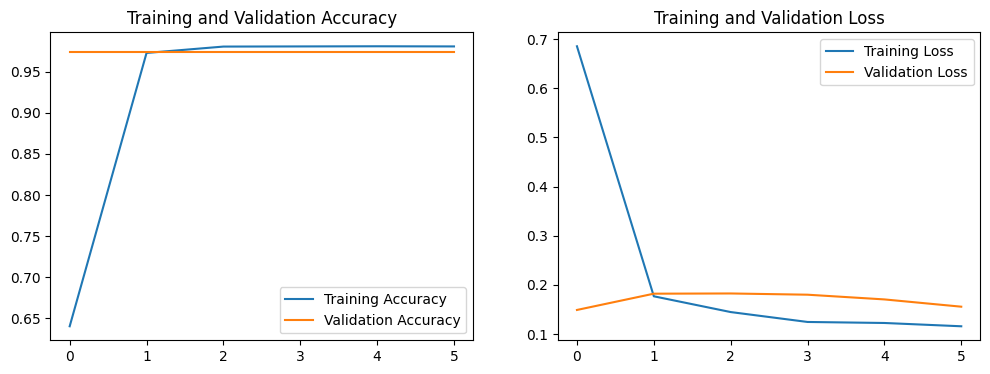

In [15]:
#train the model code
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import random
import os

# --- 1. Your Custom Augmentation Function ---
# (Pasted directly from your prompt)
def degrade_like_webcam(img):
    # Random downscale-upscale
    img = img.numpy()
    scale = random.uniform(0.5, 0.9)
    h, w = img.shape[:2]
    try:
        small = cv2.resize(img, (int(w*scale), int(h*scale)))
        img = cv2.resize(small, (w, h))
    except:
        # Failsafe in case scale is 0 or img is corrupt
        pass

    # Random JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), random.randint(25, 85)]
    _, enc = cv2.imencode('.jpg', img, encode_param)
    img = cv2.imdecode(enc, 1)

    # Random blur
    if random.random() < 0.4:
        k = random.choice([3,5])
        img = cv2.GaussianBlur(img, (k,k), 0)

    # Random noise
    if random.random() < 0.4:
        noise = np.random.normal(0, random.randint(5,20), img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    return img

# --- 2. TensorFlow Wrapper Function ---
# We must wrap your function in tf.py_function
CROP_SIZE = 64

def augment_wrapper(image, label):
    # This is the magic line
    # It tells TensorFlow to run your Python function
    [image] = tf.py_function(degrade_like_webcam, [image], [tf.uint8])

    # We must reset the shape, as py_function loses it
    image.set_shape([CROP_SIZE, CROP_SIZE, 3])

    return image, label

# --- 3. Load the Data ---
BATCH_SIZE = 32
IMG_SIZE = (CROP_SIZE, CROP_SIZE)
DATA_DIR = local_dataset_path # From Cell 1

print(f"Loading dataset from {DATA_DIR}...")

# Load the training dataset (as uint8)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load the validation dataset (NO augmentation)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names
print("Classes found:", class_names)

# --- 4. Apply Your Augmentation Function ---
# We .map() your wrapper to the training data
# --- 4. Apply Your Augmentation Function (FIXED) ---
print("Applying your 'degrade_like_webcam' augmentations...")
AUTOTUNE = tf.data.AUTOTUNE

# We must UNBATCH the dataset to run the Python function on each image
train_dataset = train_dataset.unbatch()

# Now, map your augmentation function to each single image
train_dataset = train_dataset.map(augment_wrapper, num_parallel_calls=AUTOTUNE)

# Now, RE-BATCH the data so the model receives batches
train_dataset = train_dataset.batch(BATCH_SIZE)

# Prefetch the batched dataset
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)



# --- 5. Build the Model (Functional API — required for MobileNetV2) ---

inputs = tf.keras.Input(shape=(CROP_SIZE, CROP_SIZE, 3))

# Normalize for MobileNetV2 [-1,1]
x = layers.Rescaling(1/127.5, offset=-1)(inputs)

# Base model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(CROP_SIZE, CROP_SIZE, 3)
)
base_model.trainable = False

# Forward pass through base model
x = base_model(x, training=False)

# Pool + dense layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# --- 6. Compile the Model (Ultra-Safe) ---
ultra_safe_optimizer = Adam(learning_rate=1e-5, clipnorm=1.0)
model.compile(
    optimizer=ultra_safe_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# --- 7. Train the Model ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Increased patience since training is harder
    restore_best_weights=True
)
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# ... (Plotting code is the same) ...
print("\n--- Training Complete! ---")
actual_epochs = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(actual_epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
### --- CELL 3: Save Your Model ---

# Define where to save the model on your Google Drive
MODEL_SAVE_PATH = "/content/drive/MyDrive/FuckedUP YAens/yawn_model.h5"

# Save the model
try:
    model.save(MODEL_SAVE_PATH)
    print(f"Model successfully saved to: {MODEL_SAVE_PATH}")
    print("You can now download this .h5 file to your local computer.")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved to: /content/drive/MyDrive/FuckedUP YAens/my_yawn_model.h5
You can now download this .h5 file to your local computer.


In [16]:
from google.colab import files

# Save locally in Colab
MODEL_SAVE_PATH = "/content/yawn_model.h5"

model.save(MODEL_SAVE_PATH)
print("Saved to:", MODEL_SAVE_PATH)

# Download to your computer
files.download(MODEL_SAVE_PATH)


Saved to: /content/yawn_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>